In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import gymnasium as gym
import MetaTrader5 as mt5
import joblib
import pytz
import ta
from datetime import datetime
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from gymnasium import spaces
from sklearn.preprocessing import RobustScaler
from config import *
from creds import *

RATES_CSV_PATH = "../data/rates.csv"

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1500)

def fetch_symbol_data(symbol, timeframe, n_candles):
    creds = {
        "path": MT5_PATH,
        "login": MT5_LOGIN,
        "pass": MT5_PASSWORD,
        "server": MT5_SERVER,
        "timeout": 60000,
        "portable": False
    }

    if mt5.initialize(path=creds['path'],
                    login=creds['login'],
                    password=creds['pass'],
                    server=creds['server'],
                    timeout=creds['timeout'],
                    portable=creds['portable']):
        
        print("Platform MT5 launched correctly")
    else:
        print(f"There has been a problem with initialization: {mt5.last_error()}")

    account_info = mt5.account_info()
    if account_info is None:
        print("Failed to connect to the account")
    else:
        print(f"Connected to account: {account_info.login}")

    rates = mt5.copy_rates_from(symbol, timeframe, datetime.now(pytz.utc), n_candles)
    if rates is None or len(rates) == 0:
        print("No data returned")
        print(f"Last error: {mt5.last_error()}")
    else:
        print(f"Data returned: {len(rates)} bars")

    df = pd.DataFrame(rates)
    df['time'] = pd.to_datetime(df['time'], unit='s')
    # df['weekday_cos'] = np.cos(2 * np.pi * df['time'].dt.dayofweek / 7)
    # df['weekday_sin'] = np.sin(2 * np.pi * df['time'].dt.dayofweek / 7)
    df.set_index('time', inplace=True)

    df['volume'] = df['tick_volume']

    # Remove the last row as it might have not completed yet
    df = df.iloc[:-1]

    # Trend Indicators
    df['EMA_fast'] = ta.trend.ema_indicator(df['close'], window=9)
    df['EMA_medium'] = ta.trend.ema_indicator(df['close'], window=21)
    df['EMA_slow'] = ta.trend.ema_indicator(df['close'], window=50)	
    df['MACD'] = ta.trend.macd_diff(df['close'])

    # Momentum Indicators
    df['RSI'] = ta.momentum.rsi(df['close'])
    df['Stoch'] = ta.momentum.stoch(df['high'], df['low'], df['close'])

    # Volatility Indicators
    df['BB_upper'], df['BB_middle'], df['BB_lower'] = ta.volatility.bollinger_hband(df['close']), ta.volatility.bollinger_mavg(df['close']), ta.volatility.bollinger_lband(df['close'])
    df['ATR'] = ta.volatility.average_true_range(df['high'], df['low'], df['close'])

    # Volume Indicators
    df['OBV'] = ta.volume.on_balance_volume(df['close'], df['volume'])
    df['VWAP'] = ta.volume.volume_weighted_average_price(df['high'], df['low'], df['close'], df['tick_volume'])

    df.drop(columns=['real_volume', 'tick_volume'], inplace = True)
    df.drop(columns=['spread'], inplace = True)

    df.dropna(inplace=True)
    return df

df = fetch_symbol_data("BTCUSDm", mt5.TIMEFRAME_M15, 25000)
df.to_csv(RATES_CSV_PATH)

#df = pd.read_csv(RATES_CSV_PATH)
#df.set_index('time', inplace=True)

start_datetime = df.index[0]
end_datetime = df.index[-1]
print(f"Data collected from {start_datetime} to {end_datetime}")

df_scaled = df.copy()

scaler = RobustScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_scaled), columns=df_scaled.columns, index=df_scaled.index)
df_scaled['unscaled_close'] = df['close']

print(df_scaled.tail())

# Split train/test (80/20)
split_idx = int(len(df) * 0.8)
train_data = df_scaled.iloc[:split_idx]
test_data = df_scaled.iloc[split_idx:]

Platform MT5 launched correctly
Connected to account: 208505760
Data returned: 25000 bars
Data collected from 2024-06-04 03:15:00 to 2025-02-19 06:00:00
                     close_change_pct  high_to_close  low_to_close       atr       rsi    ema_20      macd  bollinger_width      VWAP  unscaled_close
time                                                                                                                                                 
2025-02-19 05:00:00          0.159177      -0.487702     -0.311044  0.009272 -0.341401  0.805185 -1.158224        -0.069965  0.809707        95287.78
2025-02-19 05:15:00         -0.719041       0.603447      0.069999  0.013905 -0.643185  0.804209 -1.390218         0.015552  0.809142        95119.98
2025-02-19 05:30:00          0.832283      -0.459865     -0.783063  0.008228 -0.208147  0.803869 -1.280772         0.033416  0.808340        95316.42
2025-02-19 05:45:00         -0.132575      -0.153581      0.385518 -0.051033 -0.265311  0.803478 

In [5]:
from trade_environment import BitcoinTradingEnv
from stable_baselines3.common.env_util import make_vec_env
import joblib

seed_value = np.random.randint(0, 100000)
seed_value = 75443
print(f"Using seed: {seed_value}")

env = BitcoinTradingEnv(train_data)
env.action_space.seed(seed_value)
vec_env = make_vec_env(lambda: env, n_envs=1, seed=seed_value)

model = PPO("MlpPolicy", vec_env, verbose=0, n_epochs=10, learning_rate=0.00001, ent_coef=0.01, gamma=0.95, clip_range=0.2, batch_size=512, n_steps=4096)
model.learn(total_timesteps=100000, progress_bar=True)
model.save(f"./../results/{seed_value}")
joblib.dump(scaler, f"./../results/{seed_value}.pkl")

Using seed: 75443


Output()

['./../results/75443.pkl']

Training Seed: 75443
Total Reward: -5346.61
Starting Balance: 10000.0
Current Balance: 0
Total Return: -100.00%
Total Trades: 2757
Total Win Rate: 1491 (54.08%)
Long Trades: 2757
Long Win Rate: 54.08%
Short Trades: 0
Short Win Rate: 0.00%
Average Win: 42.74
Average Loss: 59.17
Average RRR: 0.72
Expected Value: -4.05
Kelly Criterion: -0.09
Half-Kelly Criterion: -0.05
Sharpe Ratio: -0.78


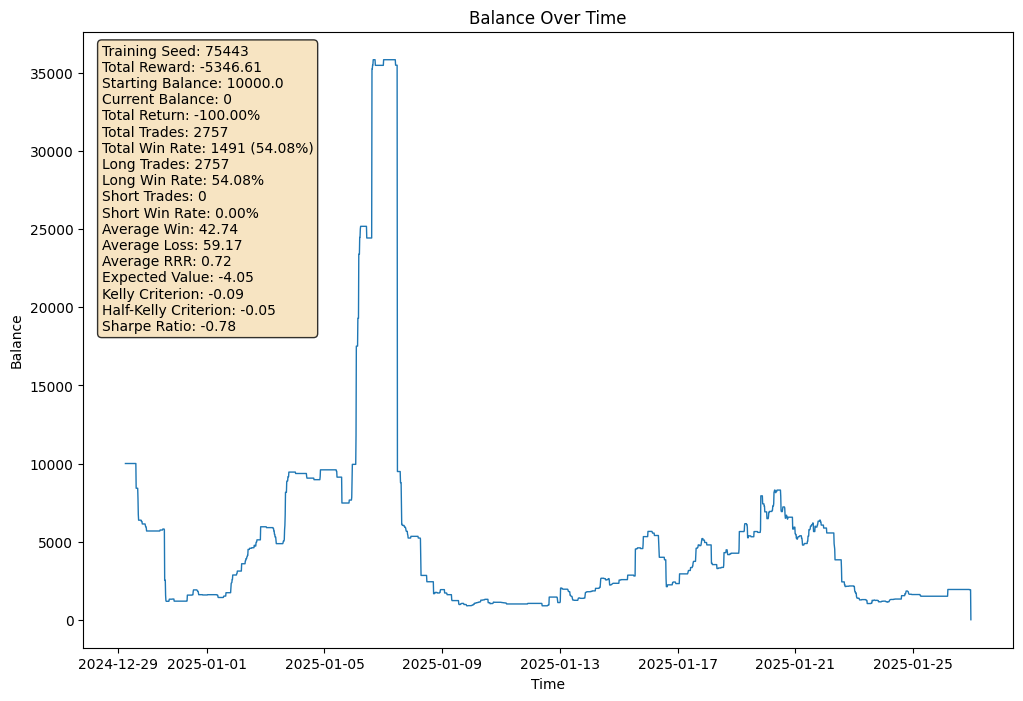

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Instantiate a test environment using test_data
test_env = BitcoinTradingEnv(test_data, initial_balance=10000.0)
test_env.action_space.seed(seed_value)

# Reset the test environment and get the initial observation
obs, info = test_env.reset()

balance_over_time = []
reward_over_time = []
actions_log = []
done = False

while not done:
    action, _ = model.predict(obs, deterministic=True)
    actions_log.append(action)
    obs, reward, terminated, truncated, info = test_env.step(action)
    
    done = terminated  # Ensure the loop exits properly
    balance_over_time.append(test_env.balance)
    reward_over_time.append(reward)

# Convert the list of completed trades to a DataFrame
trades_df = pd.DataFrame(test_env.trades)

def kelly_criterion(win_rate, win_loss_ratio):
    """
    Calculates the optimal fraction of capital to risk per trade using the Kelly Criterion.
    """
    if win_loss_ratio == 0:
        return 0.0  # Avoid division by zero
    return round(win_rate - ((1 - win_rate) / win_loss_ratio), 4)

def sharpe_ratio(returns, risk_free_rate=0.00, trading_periods=252):
    """
    Calculate the Sharpe Ratio for trading.
    """
    if len(returns) < 2: 
        return 0.0  # Avoid calculation on insufficient data
    excess_returns = np.array(returns) - (risk_free_rate / trading_periods)
    sharpe = np.mean(excess_returns) / np.std(excess_returns, ddof=1)
    return sharpe * np.sqrt(trading_periods)

total_trades = len(trades_df)
num_tp = trades_df[trades_df["pnl"] > 0.0].shape[0]
num_sl = trades_df[trades_df["pnl"] < 0.0].shape[0]

perc_tp = (num_tp / total_trades * 100) if total_trades > 0 else 0.0
perc_sl = (num_sl / total_trades * 100) if total_trades > 0 else 0.0

avg_pnl_tp = trades_df[trades_df["pnl"] > 0.0]["pnl"].mean() if num_tp > 0 else 0.0
avg_pnl_sl = trades_df[trades_df["pnl"] < 0.0]["pnl"].mean() if num_sl > 0 else 0.0

total_return = ((test_env.balance - test_env.initial_balance) / test_env.initial_balance) * 100
expected_value = trades_df["pnl"].mean() if total_trades > 0 else 0.0

if num_tp > 0:
    avg_pnl_tp = trades_df[trades_df["pnl"] > 0.0]["pnl"].mean()
else:
    avg_pnl_tp = 0.0

if num_sl > 0:
    avg_pnl_sl = abs(trades_df[trades_df["pnl"] < 0.0]["pnl"].mean())
else:
    avg_pnl_sl = 0.0

rrr = avg_pnl_tp / avg_pnl_sl if avg_pnl_sl > 0 else 0.0

num_buy = trades_df[trades_df["position"] == 1].shape[0]
num_sell = trades_df[trades_df["position"] == -1].shape[0]

buy_win_rate = (trades_df[(trades_df["position"] == 1) & (trades_df["pnl"] > 0.0)].shape[0] / num_buy * 100) if num_buy > 0 else 0.0
sell_win_rate = (trades_df[(trades_df["position"] == -1) & (trades_df["pnl"] > 0.0)].shape[0] / num_sell * 100) if num_sell > 0 else 0.0
total_win_rate = (num_tp / total_trades * 100) if total_trades > 0 else 0.0

kelly_criteria = kelly_criterion(total_win_rate / 100.0, rrr) if not np.isnan(rrr) else 0.0

# Convert PnL to percentage returns for Sharpe ratio calculation
if total_trades > 0:
    daily_returns = trades_df["pnl"] / test_env.initial_balance
    sharpe = sharpe_ratio(daily_returns)
else:
    sharpe = 0.0

# Plot balance over time using real timestamps if available
plt.figure(figsize=(12, 8))
ax = plt.gca()

if hasattr(test_data, "index"):
    timestamps = test_data.index[:len(balance_over_time)]
    ax.plot(timestamps, balance_over_time, linewidth=1, linestyle='-')
else:
    ax.plot(balance_over_time, linewidth=1, linestyle='-')

ax.set_xlabel("Time")
ax.set_ylabel("Balance")
ax.set_title("Balance Over Time")
ax.ticklabel_format(style='plain', axis='y')

# Build multiline string for performance metrics
metrics_text = (
    f"Training Seed: {seed_value}\n"
    f"Total Reward: {reward_over_time[-1]:.2f}\n"
    f"Starting Balance: {test_env.initial_balance}\n"
    f"Current Balance: {test_env.balance}\n"
    f"Total Return: {total_return:.2f}%\n"
    f"Total Trades: {total_trades}\n"
    f"Total Win Rate: {num_tp} ({perc_tp:.2f}%)\n"
    f"Long Trades: {num_buy}\n"
    f"Long Win Rate: {buy_win_rate:.2f}%\n"
    f"Short Trades: {num_sell}\n"
    f"Short Win Rate: {sell_win_rate:.2f}%\n"
    f"Average Win: {avg_pnl_tp:.2f}\n"
    f"Average Loss: {avg_pnl_sl:.2f}\n"
    f"Average RRR: {rrr:.2f}\n"
    f"Expected Value: {expected_value:.2f}\n"
    f"Kelly Criterion: {kelly_criteria:.2f}\n"
    f"Half-Kelly Criterion: {kelly_criteria / 2:.2f}\n"
    f"Sharpe Ratio: {sharpe:.2f}"
)

print(metrics_text)

# Add annotation box in the upper left-hand corner
ax.text(0.02, 0.98, metrics_text, transform=ax.transAxes,
        fontsize=10, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.savefig(f"./../results/{seed_value}.png")
plt.show()